# II. REPLICATING THE RESULTS

Train network using transfer learning 

"In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest." -cs231n notes

In [73]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os
import copy

plt.ion() # interactive mode

The problem we’re going to solve today is to train a model to classify ants and bees.

120 training images, 75 testing images

In [74]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, 
                                               shuffle = True, num_workers = 4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


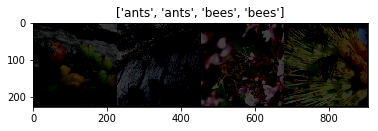

In [75]:
## Showing tensor images
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp * mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
#get batch of training examples
inputs, classes = next(iter(data_loaders['train']))

#make grid
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

### TRAINING THE MODEL

* Scheduling the learning rate
* Saving the best model

In [76]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch{}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # all epochs have training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else: 
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            #iterate over dataset
            for inputs,labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # forward, track history in train 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    #only backwards and optimize if in the train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
            #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
        
    time_elapsed = time.time() - since
        
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
        
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [77]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

In [66]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [91]:
### BASELINE MODEL

In [46]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch0/24
----------
train Loss: 0.5493 Acc: 0.7418
val Loss: 0.4713 Acc: 0.8105

Epoch1/24
----------
train Loss: 0.6242 Acc: 0.7582
val Loss: 0.6560 Acc: 0.7320

Epoch2/24
----------
train Loss: 0.5240 Acc: 0.7705
val Loss: 0.1961 Acc: 0.9085

Epoch3/24
----------
train Loss: 0.4406 Acc: 0.8115
val Loss: 0.2497 Acc: 0.8889

Epoch4/24
----------
train Loss: 0.4375 Acc: 0.8279
val Loss: 0.2339 Acc: 0.9085

Epoch5/24
----------
train Loss: 0.5868 Acc: 0.7869
val Loss: 0.2413 Acc: 0.9346

Epoch6/24
----------
train Loss: 0.5025 Acc: 0.8115
val Loss: 0.2627 Acc: 0.8954

Epoch7/24
----------
train Loss: 0.2957 Acc: 0.8770
val Loss: 0.2021 Acc: 0.9281

Epoch8/24
----------
train Loss: 0.2375 Acc: 0.9016
val Loss: 0.1984 Acc: 0.9346

Epoch9/24
----------
train Loss: 0.2992 Acc: 0.8852
val Loss: 0.1813 Acc: 0.9346

Epoch10/24
----------
train Loss: 0.2559 Acc: 0.9098
val Loss: 0.1867 Acc: 0.9346

Epoch11/24
----------
train Loss: 0.2742 Acc: 0.8893
val Loss: 0.1505 Acc: 0.9477

Epoch12/24
---

In [67]:
## With a learning rate of .001 the accuracy is 95.4%. 
## The time taken to train is ~40 minutes

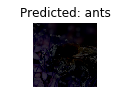

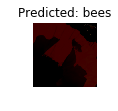

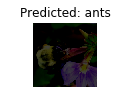

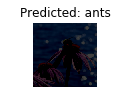

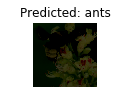

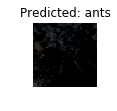

In [68]:
visualize_model(model_ft)

In [69]:
model_conv = torchvision.models.resnet18(pretrained = True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.01, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)

In [89]:
# Not converting gradients in backwards, freezing images

In [54]:
model_conv = train_model(model_conv,criterion, optimizer_conv,exp_lr_scheduler, num_epochs = 25)

Epoch0/24
----------
train Loss: 2.2048 Acc: 0.6680
val Loss: 0.4676 Acc: 0.9412

Epoch1/24
----------
train Loss: 2.9771 Acc: 0.7090
val Loss: 0.6738 Acc: 0.9477

Epoch2/24
----------
train Loss: 2.5501 Acc: 0.7746
val Loss: 5.5201 Acc: 0.6928

Epoch3/24
----------
train Loss: 4.3789 Acc: 0.7131
val Loss: 0.8595 Acc: 0.9542

Epoch4/24
----------
train Loss: 3.6565 Acc: 0.7869
val Loss: 1.3644 Acc: 0.9412

Epoch5/24
----------
train Loss: 2.3562 Acc: 0.8320
val Loss: 1.1182 Acc: 0.9281

Epoch6/24
----------
train Loss: 4.8229 Acc: 0.7377
val Loss: 1.6011 Acc: 0.9150

Epoch7/24
----------
train Loss: 1.1012 Acc: 0.8689
val Loss: 1.1908 Acc: 0.9346

Epoch8/24
----------
train Loss: 2.1012 Acc: 0.8197
val Loss: 1.0591 Acc: 0.9477

Epoch9/24
----------
train Loss: 1.9084 Acc: 0.8484
val Loss: 0.8883 Acc: 0.9608

Epoch10/24
----------
train Loss: 1.8477 Acc: 0.8074
val Loss: 0.9508 Acc: 0.9477

Epoch11/24
----------
train Loss: 1.9173 Acc: 0.8443
val Loss: 0.9021 Acc: 0.9542

Epoch12/24
---

In [70]:
## With a learning rate of .01 the accuracy is 96.1%
## The time taken to train is ~17 minutes.

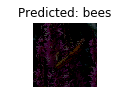

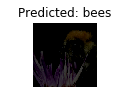

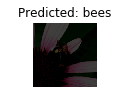

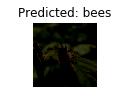

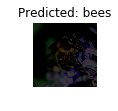

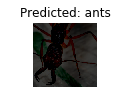

In [55]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [82]:
# Going to train With a learning rate of 0.1 using CrossEntropyLoss(). Expect lower accuracy. 

model_new = torchvision.models.resnet18(pretrained = True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_features = model_new.fc.in_features
model_new.fc = nn.Linear(num_features, 2)

model_new = model_new.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_new = optim.SGD(model_new.fc.parameters(), lr = 0.1, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_new, step_size = 7, gamma = 0.1)

In [90]:
# Running a larger learning rate on the fixed feature model... requires_grad = False

In [84]:
model_new = train_model(model_new, criterion, optimizer_new, exp_lr_scheduler, num_epochs = 25)

Epoch0/24
----------
train Loss: 8.9923 Acc: 0.7295
val Loss: 27.2762 Acc: 0.6340

Epoch1/24
----------
train Loss: 26.3861 Acc: 0.6762
val Loss: 25.6098 Acc: 0.7255

Epoch2/24
----------
train Loss: 58.3411 Acc: 0.6516
val Loss: 9.2704 Acc: 0.9346

Epoch3/24
----------
train Loss: 29.9290 Acc: 0.7623
val Loss: 16.6681 Acc: 0.8889

Epoch4/24
----------
train Loss: 20.0381 Acc: 0.8074
val Loss: 16.4544 Acc: 0.8758

Epoch5/24
----------
train Loss: 17.0210 Acc: 0.8320
val Loss: 5.2877 Acc: 0.9281

Epoch6/24
----------
train Loss: 12.8875 Acc: 0.8320
val Loss: 7.8885 Acc: 0.9150

Epoch7/24
----------
train Loss: 19.1193 Acc: 0.7828
val Loss: 6.6714 Acc: 0.9150

Epoch8/24
----------
train Loss: 14.5470 Acc: 0.8156
val Loss: 6.5729 Acc: 0.9216

Epoch9/24
----------
train Loss: 14.0385 Acc: 0.8115
val Loss: 6.3054 Acc: 0.9216

Epoch10/24
----------
train Loss: 12.7825 Acc: 0.8156
val Loss: 8.4731 Acc: 0.9216

Epoch11/24
----------
train Loss: 9.6044 Acc: 0.8402
val Loss: 9.8705 Acc: 0.9085



In [87]:
## With a learning rate of .1 the accuracy was 94.1%
## It took ~2 hours to train but I was in a very congested area that most likely added to the slow connection

In [86]:
## Changing the weight initialization patterns. 
## Changed train and val normalization from [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] to [0.300, 0.300, 0.300], [0.100, 0.100, 0.100]

In [85]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.300, 0.300, 0.300], [0.100, 0.100, 0.100])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.300, 0.300, 0.300], [0.100, 0.100, 0.100])
    ]),
}
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, 
                                               shuffle = True, num_workers = 4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [88]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch0/24
----------
train Loss: 0.5973 Acc: 0.7049
val Loss: 0.1665 Acc: 0.9412

Epoch1/24
----------
train Loss: 0.4993 Acc: 0.7787
val Loss: 0.5622 Acc: 0.7647

Epoch2/24
----------
train Loss: 0.6584 Acc: 0.7582
val Loss: 0.3110 Acc: 0.8889

Epoch3/24
----------
train Loss: 0.4494 Acc: 0.8115
val Loss: 0.2699 Acc: 0.8954

Epoch4/24
----------
train Loss: 0.5933 Acc: 0.7746
val Loss: 0.2143 Acc: 0.9216

Epoch5/24
----------
train Loss: 0.4518 Acc: 0.8197
val Loss: 0.2817 Acc: 0.9150

Epoch6/24
----------
train Loss: 0.6494 Acc: 0.7746
val Loss: 0.2776 Acc: 0.9020

Epoch7/24
----------
train Loss: 0.3719 Acc: 0.8525
val Loss: 0.3123 Acc: 0.9020

Epoch8/24
----------
train Loss: 0.4785 Acc: 0.8238
val Loss: 0.3941 Acc: 0.9020

Epoch9/24
----------
train Loss: 0.4899 Acc: 0.8156
val Loss: 0.3283 Acc: 0.9020

Epoch10/24
----------
train Loss: 0.4766 Acc: 0.8197
val Loss: 0.2542 Acc: 0.9216

Epoch11/24
----------
train Loss: 0.3638 Acc: 0.8689
val Loss: 0.2285 Acc: 0.9085

Epoch12/24
---

In [92]:
## 94.11% Accuracy

In [93]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, 
                                               shuffle = True, num_workers = 4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [96]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.1, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [97]:
## Original Model_ft with regression = True with change learning rate 0.001 -> 0.1

In [98]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch0/24
----------
train Loss: 13.0458 Acc: 0.5082
val Loss: 0.7105 Acc: 0.4575

Epoch1/24
----------
train Loss: 1.7734 Acc: 0.5041
val Loss: 3.4029 Acc: 0.4575

Epoch2/24
----------
train Loss: 0.9885 Acc: 0.4590
val Loss: 2.0228 Acc: 0.4575

Epoch3/24
----------
train Loss: 0.7623 Acc: 0.4877
val Loss: 0.8706 Acc: 0.5425

Epoch4/24
----------
train Loss: 0.8303 Acc: 0.5000
val Loss: 1.3589 Acc: 0.4510

Epoch5/24
----------
train Loss: 0.8072 Acc: 0.5492
val Loss: 0.8366 Acc: 0.4837

Epoch6/24
----------
train Loss: 0.7389 Acc: 0.5533
val Loss: 0.9331 Acc: 0.4575

Epoch7/24
----------
train Loss: 0.6989 Acc: 0.4918
val Loss: 0.8139 Acc: 0.5033

Epoch8/24
----------
train Loss: 0.6962 Acc: 0.4918
val Loss: 0.7362 Acc: 0.5294

Epoch9/24
----------
train Loss: 0.6871 Acc: 0.5697
val Loss: 0.7840 Acc: 0.5033

Epoch10/24
----------
train Loss: 0.6925 Acc: 0.5287
val Loss: 0.7993 Acc: 0.4902

Epoch11/24
----------
train Loss: 0.6883 Acc: 0.5533
val Loss: 0.7691 Acc: 0.4706

Epoch12/24
--

In [103]:
## Best Accuracy: 54%!!!! This is very different!

In [101]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 10, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [102]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch0/24
----------
train Loss: 7928926131341988864.0000 Acc: 0.5533
val Loss: 1011510833969356416.0000 Acc: 0.5425

Epoch1/24
----------
train Loss: 1733834976007.1265 Acc: 0.5369
val Loss: 8.5591 Acc: 0.5425

Epoch2/24
----------
train Loss: 10.1251 Acc: 0.5041
val Loss: 39.0686 Acc: 0.4575

Epoch3/24
----------
train Loss: 6.8834 Acc: 0.5615
val Loss: 22.8633 Acc: 0.4575

Epoch4/24
----------
train Loss: 10.1103 Acc: 0.4795
val Loss: 5.5129 Acc: 0.4575

Epoch5/24
----------
train Loss: 6.6051 Acc: 0.5328
val Loss: 0.7138 Acc: 0.4575

Epoch6/24
----------
train Loss: 13.8388 Acc: 0.4959
val Loss: 13.5593 Acc: 0.5425

Epoch7/24
----------
train Loss: 4.3435 Acc: 0.5205
val Loss: 0.7539 Acc: 0.5425

Epoch8/24
----------
train Loss: 1.4289 Acc: 0.4877
val Loss: 1.8045 Acc: 0.5425

Epoch9/24
----------
train Loss: 1.5069 Acc: 0.4959
val Loss: 0.8578 Acc: 0.4575

Epoch10/24
----------
train Loss: 1.3472 Acc: 0.4877
val Loss: 0.7206 Acc: 0.4575

Epoch11/24
----------
train Loss: 1.3880 Ac

In [100]:
## Best Accuracy also 54%

In [104]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.01, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [105]:
## Learning rate 0.01. Low accuracy when LR >= 0.1, high accuracy when LR = 0.001.

In [106]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch0/24
----------
train Loss: 3.7018 Acc: 0.5697
val Loss: 2.3313 Acc: 0.5294

Epoch1/24
----------
train Loss: 2.9380 Acc: 0.5410
val Loss: 4.1344 Acc: 0.4771

Epoch2/24
----------
train Loss: 1.5772 Acc: 0.5697
val Loss: 0.8245 Acc: 0.4510

Epoch3/24
----------
train Loss: 1.7867 Acc: 0.4959
val Loss: 1.6840 Acc: 0.5556

Epoch4/24
----------
train Loss: 1.3011 Acc: 0.5287
val Loss: 1.6289 Acc: 0.5425

Epoch5/24
----------
train Loss: 1.5909 Acc: 0.5000
val Loss: 3.2904 Acc: 0.4575

Epoch6/24
----------
train Loss: 1.0832 Acc: 0.5574
val Loss: 1.1226 Acc: 0.5556

Epoch7/24
----------
train Loss: 0.7348 Acc: 0.4877
val Loss: 0.9990 Acc: 0.5359

Epoch8/24
----------
train Loss: 0.7312 Acc: 0.4590
val Loss: 0.7439 Acc: 0.5752

Epoch9/24
----------
train Loss: 0.7294 Acc: 0.5041
val Loss: 0.7021 Acc: 0.5490

Epoch10/24
----------
train Loss: 0.7404 Acc: 0.5451
val Loss: 1.6510 Acc: 0.4575

Epoch11/24
----------
train Loss: 0.7270 Acc: 0.5082
val Loss: 0.8314 Acc: 0.5752

Epoch12/24
---

In [107]:
## Best accuracy 57.5%

In [108]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.0001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [109]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch0/24
----------
train Loss: 0.6664 Acc: 0.6107
val Loss: 0.5310 Acc: 0.7190

Epoch1/24
----------
train Loss: 0.5258 Acc: 0.7377
val Loss: 0.4075 Acc: 0.8170

Epoch2/24
----------
train Loss: 0.4522 Acc: 0.8238
val Loss: 0.3544 Acc: 0.8889

Epoch3/24
----------
train Loss: 0.4237 Acc: 0.8320
val Loss: 0.3076 Acc: 0.8889

Epoch4/24
----------
train Loss: 0.4119 Acc: 0.8197
val Loss: 0.2923 Acc: 0.9020

Epoch5/24
----------
train Loss: 0.4128 Acc: 0.7951
val Loss: 0.2763 Acc: 0.9150

Epoch6/24
----------
train Loss: 0.3676 Acc: 0.8607
val Loss: 0.2595 Acc: 0.8954

Epoch7/24
----------
train Loss: 0.3738 Acc: 0.8484
val Loss: 0.2745 Acc: 0.9085

Epoch8/24
----------
train Loss: 0.3742 Acc: 0.8361
val Loss: 0.2553 Acc: 0.9150

Epoch9/24
----------
train Loss: 0.4533 Acc: 0.7705
val Loss: 0.2547 Acc: 0.9216

Epoch10/24
----------
train Loss: 0.3315 Acc: 0.8648
val Loss: 0.2538 Acc: 0.8954

Epoch11/24
----------
train Loss: 0.3712 Acc: 0.8443
val Loss: 0.2533 Acc: 0.9150

Epoch12/24
---

In [110]:
# Best val Accuracy = 92.1%

### Hyper Parameter Manipulation Response

When manipulating the hyper parameters I found a few examples to give consistent results with the best accuracy rate that I had already found alongside one change that caused the accuracy to drastically fall. 
The initial model that I trained on was done with a Convnet which is a pretrained convolution nueral network model. This way of training a model takes in multiple level perceptrons and requires a minimal amount of preprocessing. After training using this function, I retrained my data using a convnet once more, but in this case I froze the network except for the final layer. This means that I set requires_grad = False thus backward() did not calculate the gradients when called. I then changed my learning_rate to 0.1 from 0.01 while continuing to freeze the gradient calculation using requires_grad = False. Then from there I took my initial model where gradients were found using .backward() and changed the initialization of the weights of the 'train' and 'val' normalization. I then took my intial model, with the original weights used in order to provide a baseline and change that learning rate from 0.001 to 0.1, when doing this I noticed a trend and thus did two more tests, one with this model at learning rate of 1 and one witht this model at a learning rate of .01. These last two trends were done in order to reaffirm and strengthen a trend that I had found. I will share my findings bellow. 
* One point to be mentioned is that I do understand that I did not need to duplicate my code by copying and pasting training functions when wishing to retrain under different parameters. I felt that this would allow for a more logical flow through the program when trying to read the experiments that I had done thus I did so.  

When initially training the model using convent strategies and calculating gradients as is the default, I found an accuracy of 95.4%. This is a very high and strong accuracy. I will not be touching on the time it took each model to train because they were trained at different times on different networks which could add to the difference in times taken to train.   
Then when changing the strategy of the model and setting requires_grad to False, I found an accuracy of 96.1%. This is a slight raise in accuracy but in the same range as the initial training thus not something that shows a significant change based on a differenciation of training.   
When using the same training strategy with a higher learning rate of 0.1, one magnitude higher, the accuracy again varried but in an unsubstantial range. The accuracy fell 2% from 96.1% to 94.1%. This shows a change but a consistency of range of accuracy as they both continue to find accuracy above 90%.   
When taking my initial training strategy of using requires_grad default setting of True when calling backward() and changing the weights attatched to 'train' and 'val' the accuracy again stayed in the same range. The inital accuracy of this model was 95.4%, then after training with change Normalization weights the accuracy was 94.11%. This, as the other had as well, shows a slight but negligant change in accuracy, one that needs not be looked into further as its accuracy resided in the same, strong range.  
I then retrained the model with the inital strategy and weights of model_ft as I used this as my baseline. I changed the learning rate in this case from 0.001 to 0.1. This showed a significant change! The best accuracy when training the model using this adjusted learning rate was 54.2%. I found this very interesting because I had changed the learning rate of the model that limited gradient computation in a similar fassion and found a very slight change in the accuracy. When training the model that had requires_grad set to True and had a larger learning rate, the accuracy drastically fell. This shows a change in hyper parameters that has a significant change in the accuracy of our model. I then added tests with this initial model manipulating the learning rate further. When adding to the learning rate once more, going from LR = 0.1 to LR = 1 the accuracy stayed at the bad range of ~50%. I then added a test of training with a learning rate of 0.01. This is an intermediary of the initial learning rate of 0.001 and the tested learning rate of 0.1 which showed us a very poor accuracy. When re training with a learning rate of 0.01 I again found a poor learning rate of ~50%. I then, in order to finalize a trend, trained the model with a learning rate smaller than 0.001 of 0.0001. This gave us an accuracy of higher than 90%. This led me to an important understanding which showed that in this model where requires_grad = True, if LR >= 0.01 the accuracy drops substantially to be in the range of 50% and if the LR <= 0.0001 then it will have a strong accuracy rate of over 90%. 

# Extra Credit

Created new NN alongside Pytorch tutorial which takes CIFAR10 dataset and molds a Neural Network to make predictions based on the different types of images

Files already downloaded and verified
Files already downloaded and verified


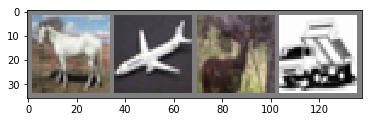

horse plane  deer truck
[1,  2000] loss: 2.253
[1,  4000] loss: 1.878
[1,  6000] loss: 1.699
[1,  8000] loss: 1.607
[1, 10000] loss: 1.543
[1, 12000] loss: 1.488
[2,  2000] loss: 1.411
[2,  4000] loss: 1.365
[2,  6000] loss: 1.348
[2,  8000] loss: 1.347
[2, 10000] loss: 1.310
[2, 12000] loss: 1.284
[3,  2000] loss: 1.222
[3,  4000] loss: 1.208
[3,  6000] loss: 1.216
[3,  8000] loss: 1.212
[3, 10000] loss: 1.194
[3, 12000] loss: 1.182
[4,  2000] loss: 1.120
[4,  4000] loss: 1.122
[4,  6000] loss: 1.109
[4,  8000] loss: 1.118
[4, 10000] loss: 1.135
[4, 12000] loss: 1.103
[5,  2000] loss: 1.028
[5,  4000] loss: 1.050
[5,  6000] loss: 1.027
[5,  8000] loss: 1.045
[5, 10000] loss: 1.059
[5, 12000] loss: 1.062
[6,  2000] loss: 0.960
[6,  4000] loss: 1.000
[6,  6000] loss: 0.972
[6,  8000] loss: 1.002
[6, 10000] loss: 1.001
[6, 12000] loss: 1.002
[7,  2000] loss: 0.908
[7,  4000] loss: 0.936
[7,  6000] loss: 0.959
[7,  8000] loss: 0.952
[7, 10000] loss: 0.945
[7, 12000] loss: 0.967
[8,  2000]

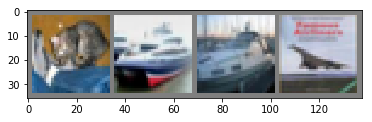

GroundTruth:    cat  ship  ship plane
Predicted:   bird plane plane plane
Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 66 %
Accuracy of   car : 73 %
Accuracy of  bird : 51 %
Accuracy of   cat : 38 %
Accuracy of  deer : 53 %
Accuracy of   dog : 56 %
Accuracy of  frog : 68 %
Accuracy of horse : 64 %
Accuracy of  ship : 67 %
Accuracy of truck : 67 %
cpu


In [125]:
import torch
import torchvision
import torchvision.transforms as transforms

## USING CIFAR10 DATASET 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images)


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Will used cpu

print(device)

In [126]:
# 60% accuracy. Not great but a much larger dataset so expected to be less good than the prior training